In [10]:
# 查看当前挂载的数据集目录, 该目录下的变更重启环境后会自动还原
# View dataset directory. 
# This directory will be recovered automatically after resetting environment. 
!ls /home/aistudio/data

In [11]:
# 查看工作区文件, 该目录下的变更将会持久保存. 请及时清理不必要的文件, 避免加载过慢.
# View personal work directory. 
# All changes under this directory will be kept even after reset. 
# Please clean unnecessary files in time to speed up environment loading. 
!ls /home/aistudio/work

In [12]:
# 如果需要进行持久化安装, 需要使用持久化路径, 如下方代码示例:
# If a persistence installation is required, 
# you need to use the persistence path as the following: 
!mkdir /home/aistudio/external-libraries
!pip install beautifulsoup4 -t /home/aistudio/external-libraries

mkdir: cannot create directory ‘/home/aistudio/external-libraries’: File exists
Looking in indexes: https://mirror.baidu.com/pypi/simple/
     |████████████████████████████████| 122kB 13.6MB/s eta 0:00:01


Epoch   0 / iter   0, loss = 0.8621
Epoch   0 / iter   1, loss = 0.8664
Epoch   0 / iter   2, loss = 1.0441
Epoch   0 / iter   3, loss = 0.7130
Epoch   0 / iter   4, loss = 1.9231
Epoch   1 / iter   0, loss = 0.7243
Epoch   1 / iter   1, loss = 0.5759
Epoch   1 / iter   2, loss = 0.7294
Epoch   1 / iter   3, loss = 0.7063
Epoch   1 / iter   4, loss = 0.5605
Epoch   2 / iter   0, loss = 0.6145
Epoch   2 / iter   1, loss = 0.5182
Epoch   2 / iter   2, loss = 0.5923
Epoch   2 / iter   3, loss = 0.5654
Epoch   2 / iter   4, loss = 0.9419
Epoch   3 / iter   0, loss = 0.4969
Epoch   3 / iter   1, loss = 0.5414
Epoch   3 / iter   2, loss = 0.4571
Epoch   3 / iter   3, loss = 0.4212
Epoch   3 / iter   4, loss = 1.1206
Epoch   4 / iter   0, loss = 0.4053
Epoch   4 / iter   1, loss = 0.4518
Epoch   4 / iter   2, loss = 0.3945
Epoch   4 / iter   3, loss = 0.3680
Epoch   4 / iter   4, loss = 0.4991
Epoch   5 / iter   0, loss = 0.4174
Epoch   5 / iter   1, loss = 0.3798
Epoch   5 / iter   2, loss =

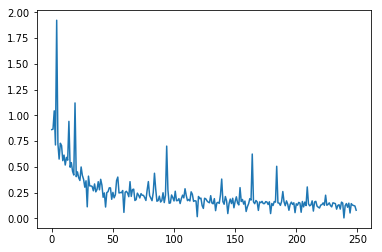

In [13]:
# 同时添加如下代码, 这样每次环境(kernel)启动的时候只要运行下方代码即可: 
# Also add the following code, 
# so that every time the environment (kernel) starts, 
# just run the following code: 
import sys 
sys.path.append('/home/aistudio/external-libraries')
import numpy as np
import matplotlib.pyplot as plt


def load_data():
    # 导入数据集
    datafile = './housing.data'
    data = np.fromfile(datafile, sep=' ')

    # 每条数据包括14项，其中前面13项是影响因素，第14项是相应的房屋价格中位数
    feature_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', \
                     'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
    feature_num = len(feature_names)

    # 数据Reshape，变成[N, 14]
    data = data.reshape([data.shape[0] // feature_num, feature_num])

    # 计算数据集的最大值，最小值，平均值
    maximums, minimums, avgs = data.max(axis=0), data.min(axis=0), \
                               data.sum(axis=0) / data.shape[0]

    # 对数据进行归一化处理，减去均值除以最大减最小
    for i in range(feature_num):
        # print(maximums[i], minimums[i], avgs[i])
        data[:, i] = (data[:, i] - avgs[i]) / (maximums[i] - minimums[i])

    # 将原数据集拆分成训练集和测试集
    # 这里使用80%的数据做训练，20%的数据做测试
    ratio = 0.8
    offset = int(data.shape[0] * ratio)
    training_data = data[:offset]
    training_data = data[:offset]
    test_data = data[offset:]
    return training_data, test_data


class Network(object):
    def __init__(self, num_of_weights):
        # 随机产生w的初始值
        # 为了保持程序每次运行结果的一致性，此处设置固定的随机数种子
        self.w = np.random.randn(num_of_weights, 1)
        self.b = 0.

    def forward(self, x):
        z = np.dot(x, self.w) + self.b
        return z

    def loss(self, z, y):
        error = z - y
        num_samples = error.shape[0]
        cost = error * error
        cost = np.sum(cost) / num_samples
        return cost

    def gradient(self, x, y):
        z = self.forward(x)
        N = x.shape[0]
        gradient_w = 1. / N * np.sum((z - y) * x, axis=0)
        gradient_w = gradient_w[:, np.newaxis]
        gradient_b = 1. / N * np.sum(z - y)
        return gradient_w, gradient_b

    def update(self, gradient_w, gradient_b, eta=0.01):
        self.w = self.w - eta * gradient_w
        self.b = self.b - eta * gradient_b

    def train(self, training_data, num_epoches, batch_size=10, eta=0.01):
        n = len(training_data)
        losses = []
        for epoch_id in range(num_epoches):
            # 在每轮迭代开始之前，将训练数据的顺序随机的打乱，
            # 然后再按每次取batch_size条数据的方式取出
            np.random.shuffle(training_data)
            # 将训练数据进行拆分，每个mini_batch包含batch_size条的数据
            mini_batches = [training_data[k:k + batch_size] for k in range(0, n, batch_size)]
            for iter_id, mini_batch in enumerate(mini_batches):
                # print(self.w.shape)
                # print(self.b)
                x = mini_batch[:, :-1]
                y = mini_batch[:, -1:]
                a = self.forward(x)
                loss = self.loss(a, y)
                gradient_w, gradient_b = self.gradient(x, y)
                self.update(gradient_w, gradient_b, eta)
                losses.append(loss)
                print('Epoch {:3d} / iter {:3d}, loss = {:.4f}'.
                      format(epoch_id, iter_id, loss))

        return losses


# 载入数据
train_data, test_data = load_data()

# 网络初始化
net = Network(13)
# 开始训练
losses = net.train(train_data, num_epoches=50, batch_size=100, eta=0.1)

# 画出损失函数的变化趋势
plot_x = np.arange(len(losses))
plot_y = np.array(losses)
plt.plot(plot_x, plot_y)
plt.show()

请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 